In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

In [44]:
using QuantumOptics
import PyPlot
const plt = PyPlot;
using Random, Distributions
using ProgressBars
using DelimitedFiles
Random.seed!(0)

# Locals
include("./noise_sim.jl")
using .NoiseSim: construct_MS_chamber, get_MS_noise, get_single_qubit_gate_noise

In this notebook, we specifically model the parameters $\{ \texttt{I, f\_cl}, \; \nu, \; \varphi \}$ as being normally distributed random variables. These Gaussians are centered at the optimal/calibrated values, and their standard deviations serve as an indicator of the "goodness" or "badness" of the computer.

However, the functions $\texttt{get\_MS\_noise()}$, $\texttt{get\_RX\_noise}$, and $\texttt{get\_RY\_noise}$ are general: they accept any distribution* of the parameters (e.g. Gaussian, Poisson, etc.). 

*This means the actual Julia objects can be either probability distributions or simply vectors.

Some useful globals

In [45]:
########## Calcium-40 ion ##########

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])


########## Some calibrated values for the Molmer-sorensen gate ##########

μ_I_MS = 94326.65907221894 # laser-intensity, W/cm^2
μ_ν_MS = 2.5e5 # trap-frequency, Hz
μ_f_cl_MS = 4.111550352057269e14 # laser-frequency, Hz
μ_ϕ_MS = 0.0 # relative phase between red and blue sidebands 
π2_TIME_MS = 1e-4 # gate-time for an MS(π/2) gate
AC_CORRECTION = 0.0 # ac-stark shift correction, Hz
B_STRENGTH_MS = 6e-4 # magnetic field strength, T


########## Some calibrated values for the single-qubit gates ##########

μ_I_SINGLE = 4.123759471808808e6
μ_ν_SINGLE = 1e6 # Although it shouldn't really matter
μ_f_cl_SINGLE = 4.111550340833542e14
μ_ϕ_SINGLE = 0.0
π2_TIME_SINGLE = 1e-6
B_STRENGTH_SINGLE = 4e-4

########## Some useful quantum states ##########
ket_0 = CALCIUM40["S"]
ket_1 = CALCIUM40["D"]

# Computational basis
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell basis
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10);

chamber_temp = construct_MS_chamber(I=μ_I_MS, ν=μ_ν_MS, ν_target=μ_ν_MS, f_cl=μ_f_cl_MS, ϕ=μ_ϕ_MS, π2_time=π2_TIME_MS, B=B_STRENGTH_MS, ac_correction=AC_CORRECTION)
ket_0_mot = IonSim.modes(chamber_temp)[1][0]
chamber_temp = Nothing

########## Other useful globals ##########
C0 = 2.99792458e8 # Speed of light, m/s
δλ_MAX = 1e-15 # Larger than this and the simulation becomes unstable
N_SHOTS = Int(1e3);


Helper function for plotting state populations

In [46]:
function plot_populations(tout, sol)

    # compute expectation values
    ρ_00 = dm(ket_00 ⊗ ket_0_mot)
    ρ_01 = dm(ket_01 ⊗ ket_0_mot)
    ρ_10 = dm(ket_10 ⊗ ket_0_mot)
    ρ_11 = dm(ket_11 ⊗ ket_0_mot)
    ρ_00_p_i11 = dm(ket_00_p_i11 ⊗ ket_0_mot)
    ρ_00_m_i11 = dm(ket_00_m_i11 ⊗ ket_0_mot)
    ρ_01_p_i10 = dm(ket_01_p_i10 ⊗ ket_0_mot)
    ρ_01_m_i10 = dm(ket_01_m_i10 ⊗ ket_0_mot)

    prob_00 = expect(ρ_00, sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell basis")

    return fig
end

plot_populations (generic function with 1 method)

# 1. "Good" computer

Average fidelity $\geq 0.99$ for all gates:
- Fully entangling Molmer-Sorensen: $\text{MS}(\phi_0=0, \phi_1=0, \theta=\pi/2)$
- $RX(\pi/2)$
- $RY(\pi/2)$

In [47]:
σ_I_good = 2.5e2 # W/m^2
σ_f_cl_good = 2.5e2 # Hz
σ_ν_good = 2.5e2 # Hz
σ_ϕ_good = 0.005π # rad

0.015707963267948967

### 1.a. $\text{MS}(0, 0, \pi/2)$ 

In [48]:
Normal_I_good_MS = Normal(μ_I_MS, σ_I_good)
Normal_f_cl_good_MS = Normal(μ_f_cl_MS, σ_f_cl_good)
Normal_ν_good_MS = Normal(μ_ν_MS, σ_ν_good)
Normal_ϕ_good_MS = Normal(μ_ϕ_MS, σ_ϕ_good)

fidelities_good_MS, fidelities_el_good_MS, entropies_good_MS = get_MS_noise(I_dist = Normal_I_good_MS, 
                                            f_cl_dist = Normal_f_cl_good_MS, 
                                            ν_dist = Normal_ν_good_MS, 
                                            ϕ_dist = Normal_ϕ_good_MS, 
                                            π2_time = π2_TIME_MS, 
                                            B = B_STRENGTH_MS, 
                                            ac_correction = AC_CORRECTION, 
                                            ν_target = μ_ν_MS, 
                                            n_shots=N_SHOTS)

writedlm("noise_sim_out/fidelities_good_MS_n$N_SHOTS.csv",  fidelities_good_MS, ',')
writedlm("noise_sim_out/fidelities_el_good_MS_n$N_SHOTS.csv",  fidelities_el_good_MS, ',')
writedlm("noise_sim_out/entropies_good_MS_n$N_SHOTS.csv",  entropies_good_MS, ',')

(Any[0.9960056332342149, 0.9989523726189716, 0.997492707188305, 0.9973885269279308, 0.9978468285539291, 0.9920075521011127, 0.992935404792973, 0.9972584790869198, 0.999237863767682, 0.9935101782056213  …  0.9923442929098139, 0.9958216297679275, 0.9991167562100775, 0.9714706477476878, 0.999367519876425, 0.9910246338364749, 0.9957305057882261, 0.9995753713052976, 0.9994272277783798, 0.997755843156966], Any[0.9960161879900045, 0.9989643210653727, 0.9975056643690126, 0.9974336234689505, 0.9978575918765442, 0.9921295772282552, 0.9930236736633709, 0.9972845526722545, 0.9992448138254131, 0.9935863547234733  …  0.9924219866801395, 0.995842228202109, 0.9991314755691165, 0.9716902558926508, 0.9993778189295769, 0.9911816768541089, 0.9957620027380815, 0.999591565136084, 0.9994369460743895, 0.9978022149760807], Any[0.026199546731577296 + 0.0im, 0.012984779037262067 + 0.0im, 0.022312113381145693 + 0.0im, 0.019545891954509325 + 0.0im, 0.013672332539608766 + 0.0im, 0.017266002807447757 + 0.0im, 0.0148

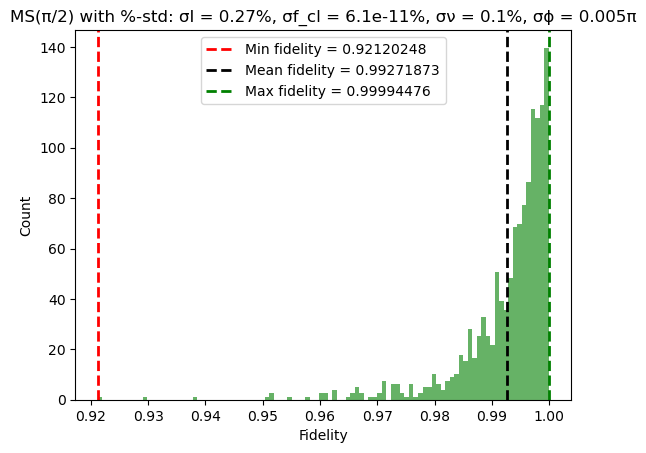

In [49]:
fig = plt.figure()
plt.hist(fidelities_good_MS, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_good_MS), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_good_MS); digits=8))")
plt.axvline(mean(fidelities_good_MS), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_good_MS); digits=8))")
plt.axvline(maximum(fidelities_good_MS), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_good_MS); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("MS(π/2) with %-std: σI = $(round(100*σ_I_good/μ_I_MS, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_good/μ_f_cl_MS, sigdigits=2))%, σν = $(round(100*σ_ν_good/μ_ν_MS, sigdigits=2))%, σϕ = $(σ_ϕ_good/π)π")
plt.legend()
plt.display(fig)

### 1.b. $RX(\pi/2)$

In [51]:
Normal_I_good_SINGLE = Normal(μ_I_SINGLE, σ_I_good)
Normal_f_cl_good_SINGLE = Normal(μ_f_cl_SINGLE, σ_f_cl_good)
Normal_ν_good_SINGLE = Normal(μ_ν_SINGLE, σ_ν_good)
Normal_ϕ_good_RX = Normal(0, σ_ϕ_good)

fidelities_good_RX, fidelities_el_good_RX, entropies_good_RX = get_single_qubit_gate_noise(gate_type = "RX",
                                    I_dist = Normal_I_good_SINGLE, # Normal_I_good_SINGLE, 
                                    f_cl_dist = Normal_f_cl_good_SINGLE , # Normal_f_cl_good_SINGLE, 
                                    ν_dist = Normal_ν_good_SINGLE, # Normal_ν_good_SINGLE, 
                                    ϕ_dist = Normal_ϕ_good_RX, #Normal_ϕ_good_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_good_RX_n$N_SHOTS.csv",  fidelities_good_RX, ',')
writedlm("noise_sim_out/fidelities_el_good_RX_n$N_SHOTS.csv",  fidelities_el_good_RX, ',')
writedlm("noise_sim_out/entropies_good_RX_n$N_SHOTS.csv",  entropies_good_RX, ',')

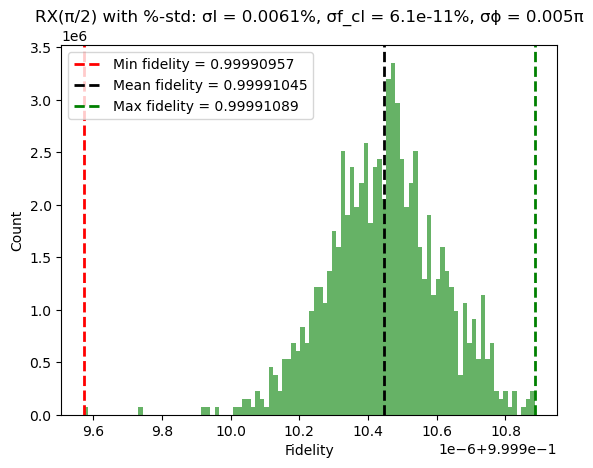

In [52]:
fig = plt.figure()
plt.hist(fidelities_good_RX, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_good_RX), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_good_RX); digits=8))")
plt.axvline(mean(fidelities_good_RX), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_good_RX); digits=8))")
plt.axvline(maximum(fidelities_good_RX), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_good_RX); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RX(π/2) with %-std: σI = $(round(100*σ_I_good/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_good/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_good/π)π")
plt.legend()
plt.display(fig)

### 1.c. $RY(\pi/2)$

In [55]:
Normal_ϕ_good_RY = Normal(π/2, σ_ϕ_good)

fidelities_good_RY, fidelities_el_good_RY, entropies_good_RY = get_single_qubit_gate_noise(gate_type = "RY",
                                    I_dist = Normal_I_good_SINGLE, # Normal_I_good_SINGLE, 
                                    f_cl_dist = Normal_f_cl_good_SINGLE , # Normal_f_cl_good_SINGLE, 
                                    ν_dist = Normal_ν_good_SINGLE, # Normal_ν_good_SINGLE, 
                                    ϕ_dist = Normal_ϕ_good_RY, #Normal_ϕ_good_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_good_RY_n$N_SHOTS.csv",  fidelities_good_RY, ',')
writedlm("noise_sim_out/fidelities_el_good_RY_n$N_SHOTS.csv",  fidelities_el_good_RY, ',')
writedlm("noise_sim_out/entropies_good_RY_n$N_SHOTS.csv",  entropies_good_RY, ',')

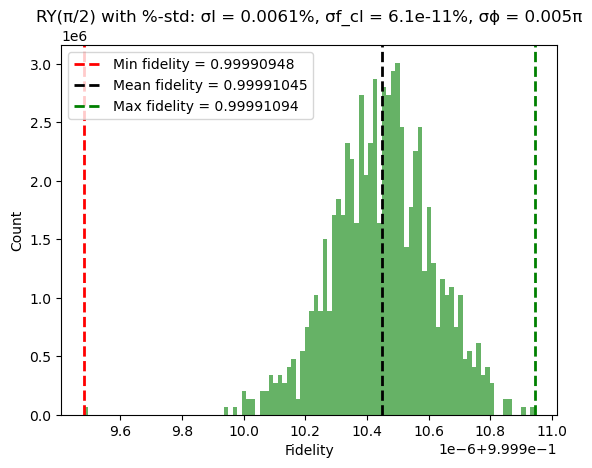

In [56]:
fig = plt.figure()
plt.hist(fidelities_good_RY, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_good_RY), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_good_RY); digits=8))")
plt.axvline(mean(fidelities_good_RY), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_good_RY); digits=8))")
plt.axvline(maximum(fidelities_good_RY), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_good_RY); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RY(π/2) with %-std: σI = $(round(100*σ_I_good/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_good/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_good/π)π")
plt.legend()
plt.display(fig)

# 2. "Bad" computer

Average fidelity $\geq 0.95$ for all gates

In [58]:
σ_I_bad = 5e2 # W/m^2
σ_f_cl_bad = 5e2 # Hz
σ_ν_bad = 1e3 # Hz
σ_ϕ_bad = 0.01π # rad

0.031415926535897934

### 2.a. $\text{MS}(0,0,\pi/2)$

In [59]:
Normal_I_bad_MS = Normal(μ_I_MS, σ_I_bad)
Normal_f_cl_bad_MS = Normal(μ_f_cl_MS, σ_f_cl_bad)
Normal_ν_bad_MS = Normal(μ_ν_MS, σ_ν_bad)
Normal_ϕ_bad_MS = Normal(μ_ϕ_MS, σ_ϕ_bad)

fidelities_bad_MS, fidelities_el_bad_MS, entropies_bad_MS = get_MS_noise(I_dist = Normal_I_bad_MS, 
                                            f_cl_dist = Normal_f_cl_bad_MS, 
                                            ν_dist = Normal_ν_bad_MS, 
                                            ϕ_dist = Normal_ϕ_bad_MS, 
                                            π2_time = π2_TIME_MS, 
                                            B = B_STRENGTH_MS, 
                                            ac_correction = AC_CORRECTION, 
                                            ν_target = μ_ν_MS, 
                                            n_shots=N_SHOTS)

writedlm("noise_sim_out/fidelities_bad_MS_n$N_SHOTS.csv",  fidelities_bad_MS, ',')
writedlm("noise_sim_out/fidelities_el_bad_MS_n$N_SHOTS.csv",  fidelities_el_bad_MS, ',')
writedlm("noise_sim_out/entropies_bad_MS_n$N_SHOTS.csv",  entropies_bad_MS, ',')

(Any[0.9974338393365834, 0.9956776886974605, 0.9282801438224199, 0.9592298528048633, 0.8861199006205045, 0.9601287171899419, 0.9775176550484144, 0.9778707720969518, 0.8871772130159987, 0.9653926544657463  …  0.9800520979748556, 0.9965014590403578, 0.8625053779080961, 0.9898062412434578, 0.9875308427030759, 0.9586248924758407, 0.8817891386422193, 0.9925996996325319, 0.9941186128480324, 0.9979566531990666], Any[0.9974993306542392, 0.9956910967481429, 0.9310105701028706, 0.9600636531321161, 0.8889273137757269, 0.9605832746101637, 0.9777734179388575, 0.9780611100246377, 0.887453415852439, 0.9659240675270582  …  0.9804905493708611, 0.9965117500205192, 0.8691552412522682, 0.9899159335173858, 0.9876222969109663, 0.9590774285564297, 0.8839646415103883, 0.9927069641314068, 0.994232414055829, 0.997979255274178], Any[0.013862397431915262 + 0.0im, 0.040200538333575335 + 0.0im, 0.33891060351640273 + 0.0im, 0.22625023633176256 + 0.0im, 0.3722102813496122 + 0.0im, 0.11732216100180423 + 0.0im, 0.14758

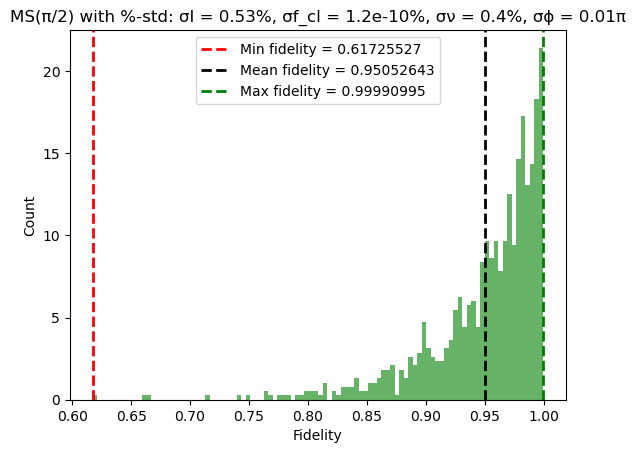

In [60]:
fig = plt.figure()
plt.hist(fidelities_bad_MS, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_bad_MS), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_bad_MS); digits=8))")
plt.axvline(mean(fidelities_bad_MS), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_bad_MS); digits=8))")
plt.axvline(maximum(fidelities_bad_MS), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_bad_MS); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("MS(π/2) with %-std: σI = $(round(100*σ_I_bad/μ_I_MS, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_bad/μ_f_cl_MS, sigdigits=2))%, σν = $(round(100*σ_ν_bad/μ_ν_MS, sigdigits=2))%, σϕ = $(σ_ϕ_bad/π)π")
plt.legend()
plt.display(fig)

### 2.b. $RX(\pi/2)$

In [61]:
Normal_I_bad_SINGLE = Normal(μ_I_SINGLE, σ_I_bad)
Normal_f_cl_bad_SINGLE = Normal(μ_f_cl_SINGLE, σ_f_cl_bad)
Normal_ν_bad_SINGLE = Normal(μ_ν_SINGLE, σ_ν_bad)
Normal_ϕ_bad_RX = Normal(0, σ_ϕ_bad)

fidelities_bad_RX, fidelities_el_bad_RX, entropies_bad_RX = get_single_qubit_gate_noise(gate_type = "RX",
                                    I_dist = Normal_I_bad_SINGLE, # Normal_I_bad_SINGLE, 
                                    f_cl_dist = Normal_f_cl_bad_SINGLE , # Normal_f_cl_bad_SINGLE, 
                                    ν_dist = Normal_ν_bad_SINGLE, # Normal_ν_bad_SINGLE, 
                                    ϕ_dist = Normal_ϕ_bad_RX, #Normal_ϕ_bad_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_bad_RX_n$N_SHOTS.csv",  fidelities_bad_RX, ',')
writedlm("noise_sim_out/fidelities_el_bad_RX_n$N_SHOTS.csv",  fidelities_el_bad_RX, ',')
writedlm("noise_sim_out/entropies_bad_RX_n$N_SHOTS.csv",  entropies_bad_RX, ',')

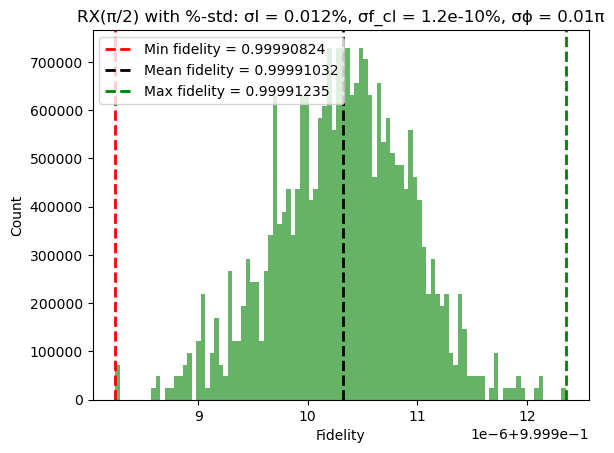

In [62]:
fig = plt.figure()
plt.hist(fidelities_bad_RX, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_bad_RX), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_bad_RX); digits=8))")
plt.axvline(mean(fidelities_bad_RX), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_bad_RX); digits=8))")
plt.axvline(maximum(fidelities_bad_RX), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_bad_RX); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RX(π/2) with %-std: σI = $(round(100*σ_I_bad/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_bad/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_bad/π)π")
plt.legend()
plt.display(fig)

### 2.c. $RY(\pi/2)$

In [63]:
Normal_ϕ_bad_RY = Normal(π/2, σ_ϕ_bad)

fidelities_bad_RY, fidelities_el_bad_RY, entropies_bad_RY = get_single_qubit_gate_noise(gate_type = "RY",
                                    I_dist = Normal_I_bad_SINGLE, # Normal_I_bad_SINGLE, 
                                    f_cl_dist = Normal_f_cl_bad_SINGLE , # Normal_f_cl_bad_SINGLE, 
                                    ν_dist = Normal_ν_bad_SINGLE, # Normal_ν_bad_SINGLE, 
                                    ϕ_dist = Normal_ϕ_bad_RY, #Normal_ϕ_bad_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_bad_RY_n$N_SHOTS.csv",  fidelities_bad_RY, ',')
writedlm("noise_sim_out/fidelities_el_bad_RY_n$N_SHOTS.csv",  fidelities_el_bad_RY, ',')
writedlm("noise_sim_out/entropies_bad_RY_n$N_SHOTS.csv",  entropies_bad_RY, ',')

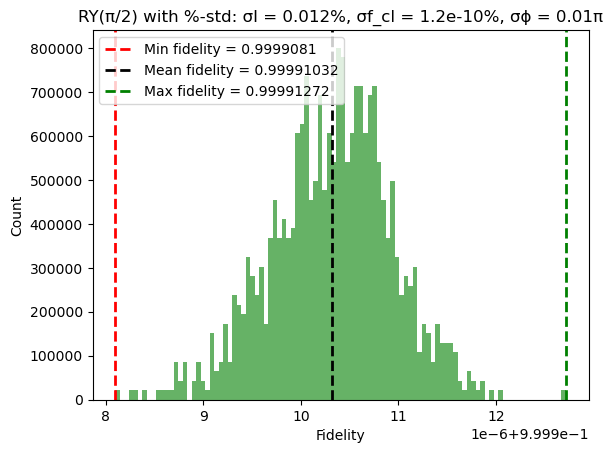

In [64]:
fig = plt.figure()
plt.hist(fidelities_bad_RY, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_bad_RY), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_bad_RY); digits=8))")
plt.axvline(mean(fidelities_bad_RY), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_bad_RY); digits=8))")
plt.axvline(maximum(fidelities_bad_RY), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_bad_RY); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RY(π/2) with %-std: σI = $(round(100*σ_I_bad/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_bad/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_bad/π)π")
plt.legend()
plt.display(fig)

# 3. Computer that only sucks at two-qubit gates

i.e. low variance in all parameters besides trap-frequency $\nu$

In [65]:
σ_I_mid = 2.5e2 # W/m^2
σ_f_cl_mid = 2.5e2 # Hz
σ_ν_mid = 1e3 # Hz
σ_ϕ_mid = 0.005π # rad

0.015707963267948967

### 3.a. $\text{MS}(0,0,\pi/2)$

In [66]:
Normal_I_mid_MS = Normal(μ_I_MS, σ_I_mid)
Normal_f_cl_mid_MS = Normal(μ_f_cl_MS, σ_f_cl_mid)
Normal_ν_mid_MS = Normal(μ_ν_MS, σ_ν_mid)
Normal_ϕ_mid_MS = Normal(μ_ϕ_MS, σ_ϕ_mid)

fidelities_mid_MS, fidelities_el_mid_MS, entropies_mid_MS = get_MS_noise(I_dist = Normal_I_mid_MS, 
                                            f_cl_dist = Normal_f_cl_mid_MS, 
                                            ν_dist = Normal_ν_mid_MS, 
                                            ϕ_dist = Normal_ϕ_mid_MS, 
                                            π2_time = π2_TIME_MS, 
                                            B = B_STRENGTH_MS, 
                                            ac_correction = AC_CORRECTION, 
                                            ν_target = μ_ν_MS, 
                                            n_shots=N_SHOTS)

writedlm("noise_sim_out/fidelities_mid_MS_n$N_SHOTS.csv",  fidelities_mid_MS, ',')
writedlm("noise_sim_out/fidelities_el_mid_MS_n$N_SHOTS.csv",  fidelities_el_mid_MS, ',')
writedlm("noise_sim_out/entropies_mid_MS_n$N_SHOTS.csv",  entropies_mid_MS, ',')

In [ ]:
Normal_I_mid_MS = Normal(μ_I_MS, σ_I_mid)
Normal_f_cl_mid_MS = Normal(μ_f_cl_MS, σ_f_cl_mid)
Normal_ν_mid_MS = Normal(μ_ν_MS, σ_ν_mid)
Normal_ϕ_mid_MS = Normal(μ_ϕ_MS, σ_ϕ_mid)

fidelities_mid_MS, fidelities_el_mid_MS, entropies_mid_MS = get_MS_noise(I_dist = Normal_I_mid_MS, 
                                            f_cl_dist = Normal_f_cl_mid_MS, 
                                            ν_dist = Normal_ν_mid_MS, 
                                            ϕ_dist = Normal_ϕ_mid_MS, 
                                            π2_time = π2_TIME_MS, 
                                            B = B_STRENGTH_MS, 
                                            ac_correction = AC_CORRECTION, 
                                            ν_target = μ_ν_MS, 
                                            n_shots=N_SHOTS)

### 3.b. $RX(\pi/2)$

In [ ]:
Normal_I_mid_SINGLE = Normal(μ_I_SINGLE, σ_I_mid)
Normal_f_cl_mid_SINGLE = Normal(μ_f_cl_SINGLE, σ_f_cl_mid)
Normal_ν_mid_SINGLE = Normal(μ_ν_SINGLE, σ_ν_mid)
Normal_ϕ_mid_RX = Normal(0, σ_ϕ_mid)

fidelities_mid_RX, fidelities_el_mid_RX, entropies_mid_RX = get_single_qubit_gate_noise(gate_type = "RX",
                                    I_dist = Normal_I_mid_SINGLE, # Normal_I_mid_SINGLE, 
                                    f_cl_dist = Normal_f_cl_mid_SINGLE , # Normal_f_cl_mid_SINGLE, 
                                    ν_dist = Normal_ν_mid_SINGLE, # Normal_ν_mid_SINGLE, 
                                    ϕ_dist = Normal_ϕ_mid_RX, #Normal_ϕ_mid_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_mid_RX_n$N_SHOTS.csv",  fidelities_mid_RX, ',')
writedlm("noise_sim_out/fidelities_el_mid_RX_n$N_SHOTS.csv",  fidelities_el_mid_RX, ',')
writedlm("noise_sim_out/entropies_mid_RX_n$N_SHOTS.csv",  entropies_mid_RX, ',')

In [ ]:
fig = plt.figure()
plt.hist(fidelities_mid_RX, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_mid_RX), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_mid_RX); digits=8))")
plt.axvline(mean(fidelities_mid_RX), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_mid_RX); digits=8))")
plt.axvline(maximum(fidelities_mid_RX), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_mid_RX); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RX(π/2) with %-std: σI = $(round(100*σ_I_mid/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_mid/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_mid/π)π")
plt.legend()
plt.display(fig)

### 3.c. $RY(\pi/2)$

In [ ]:
Normal_ϕ_mid_RY = Normal(π/2, σ_ϕ_mid)

fidelities_mid_RY, fidelities_el_mid_RY, entropies_mid_RY = get_single_qubit_gate_noise(gate_type = "RY",
                                    I_dist = Normal_I_mid_SINGLE, # Normal_I_mid_SINGLE, 
                                    f_cl_dist = Normal_f_cl_mid_SINGLE , # Normal_f_cl_mid_SINGLE, 
                                    ν_dist = Normal_ν_mid_SINGLE, # Normal_ν_mid_SINGLE, 
                                    ϕ_dist = Normal_ϕ_mid_RY, #Normal_ϕ_mid_RX, 
                                    π2_time = π2_TIME_SINGLE, 
                                    B = B_STRENGTH_SINGLE, 
                                    n_shots=N_SHOTS);

writedlm("noise_sim_out/fidelities_mid_RY_n$N_SHOTS.csv",  fidelities_mid_RY, ',')
writedlm("noise_sim_out/fidelities_el_mid_RY_n$N_SHOTS.csv",  fidelities_el_mid_RY, ',')
writedlm("noise_sim_out/entropies_mid_RY_n$N_SHOTS.csv",  entropies_mid_RY, ',')

In [ ]:
fig = plt.figure()
plt.hist(fidelities_mid_RY, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_mid_RY), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_mid_RY); digits=8))")
plt.axvline(mean(fidelities_mid_RY), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_mid_RY); digits=8))")
plt.axvline(maximum(fidelities_mid_RY), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_mid_RY); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("RY(π/2) with %-std: σI = $(round(100*σ_I_mid/μ_I_SINGLE, sigdigits=2))%, σf_cl = $(round(100*σ_f_cl_mid/μ_f_cl_SINGLE, sigdigits=2))%, σϕ = $(σ_ϕ_mid/π)π")
plt.legend()
plt.display(fig)